In [1]:
import json
import os
import glob

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
import cv2 as cv
from operator import itemgetter

In [2]:
SCITSR_PATH = '/Users/admin/Developer/table-recognition/data/SciTSR'
# NOTE: change the path to your dataset above 👆

SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [3]:
def get_files(folders, ext):
    total_files = []
    for folder in folders:
        files = glob.glob(folder + '/*.' + ext)
        files.sort()
        total_files.extend(files)
    return total_files

In [4]:
SCITSR_TRAIN_IMG = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = get_files([SCITSR_TRAIN_IMG], 'png')
len(imgs_paths)

12000

In [5]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"* Error: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

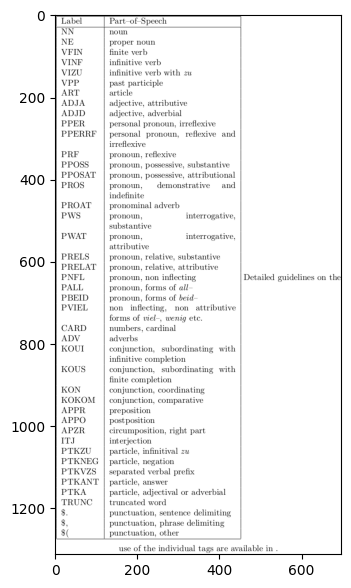

Shape: (1312, 697, 3)


In [7]:
# img_path = imgs_paths[15]
img_path = os.path.join(SCITSR_TRAIN_IMG, '9502038.1' + '.png')
img = load_img(img_path)
view_imgs([img])
print(f'Shape: {img.shape}')

In [8]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_imgs([img_pdf])
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

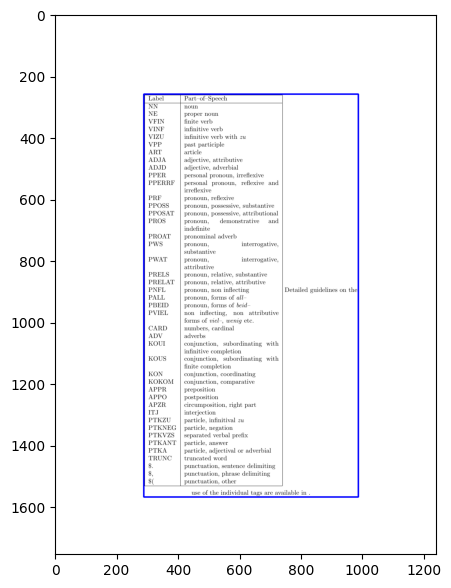

Shape: (1754, 1241, 3)
Top left: (257, 288)
Bottom right: (1568, 985)


In [9]:
img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')

left, top, right, bottom = get_table_pos(img_pdf_path, True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [10]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False):
    Chunks = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          Chunks.append((c['text'], [int(l), int(t), int(r), int(b)]))
        #   Chunks.append((c['text'], [int(l), int(t)-5, int(r), int(b)]))
    return Chunks

In [11]:
img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')

chunks = read_chunk(img_chunk_path, left, top, True)

OG       : 145 708 169 713 -- Label
Converted: 14 22 64 11
OG       : 201 708 268 713 -- Part–of–Speech
Converted: 130 22 270 11
OG       : 145 695 160 700 -- NN
Converted: 14 49 45 38
OG       : 201 695 223 700 -- noun
Converted: 130 49 176 38
OG       : 145 684 159 688 -- NE
Converted: 14 72 43 63
OG       : 201 684 254 688 -- proper noun
Converted: 130 72 241 63
OG       : 145 672 170 677 -- VFIN
Converted: 14 97 66 86
OG       : 201 672 245 677 -- ﬁnite verb
Converted: 130 97 222 86
OG       : 145 660 170 665 -- VINF
Converted: 14 122 66 111
OG       : 201 660 261 665 -- inﬁnitive verb
Converted: 130 122 255 111
OG       : 145 648 170 653 -- VIZU
Converted: 14 147 66 136
OG       : 201 648 297 653 -- inﬁnitive verb with zu
Converted: 130 147 330 136
OG       : 145 636 166 641 -- VPP
Converted: 14 172 57 161
OG       : 201 636 264 641 -- past participle
Converted: 130 172 261 161
OG       : 145 624 166 629 -- ART
Converted: 14 197 57 186
OG       : 201 624 228 629 -- article
Convert

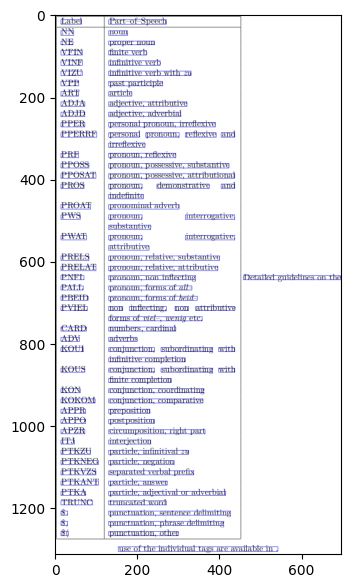

In [12]:
img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_imgs([img_draw])

In [13]:
def read_cells(struct_path):
    Cells = []
    nRow, nCol = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if content is None: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            nRow = max(nRow, er+1)
            nCol = max(nCol, ec+1)
            Cells.append({'id': id, 'range': [sr, er, sc, ec], 'content': content})

    Cells = sorted(Cells, key=itemgetter('id'))

    return nRow, nCol, Cells

In [14]:
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')

n_rows, n_cols, cells = read_cells(img_struct_path)

In [15]:
cells

[{'id': 0, 'range': [0, 0, 0, 0], 'content': ['Label']},
 {'id': 1, 'range': [0, 0, 1, 1], 'content': ['Part–of–Speech']},
 {'id': 2, 'range': [1, 1, 0, 0], 'content': ['NN']},
 {'id': 3, 'range': [1, 1, 1, 1], 'content': ['noun']},
 {'id': 4, 'range': [2, 2, 0, 0], 'content': ['NE']},
 {'id': 5, 'range': [2, 2, 1, 1], 'content': ['proper', 'noun']},
 {'id': 6, 'range': [3, 3, 0, 0], 'content': ['VFIN']},
 {'id': 7, 'range': [3, 3, 1, 1], 'content': ['ﬁnite', 'verb']},
 {'id': 8, 'range': [4, 4, 0, 0], 'content': ['VINF']},
 {'id': 9, 'range': [4, 4, 1, 1], 'content': ['inﬁnitive', 'verb']},
 {'id': 10, 'range': [5, 5, 0, 0], 'content': ['VIZU']},
 {'id': 11,
  'range': [5, 5, 1, 1],
  'content': ['inﬁnitive', 'verb', 'with', 'zu']},
 {'id': 12, 'range': [6, 6, 0, 0], 'content': ['VPP']},
 {'id': 13, 'range': [6, 6, 1, 1], 'content': ['past', 'participle']},
 {'id': 14, 'range': [7, 7, 0, 0], 'content': ['ART']},
 {'id': 15, 'range': [7, 7, 1, 1], 'content': ['article']},
 {'id': 16, '

In [16]:
def update_cells(cells, chunks):
    ChunkSkip = 0
    for i, c in enumerate(cells):
        if c['content'] == [] or \
            i - ChunkSkip >= len(chunks):
            cells[i].update({'pos': [0,0,0,0]})
            ChunkSkip += 1
        else:
            cells[i].update({'pos': chunks[i-ChunkSkip][1]})
        if c['range'][1] > c['range'][0]:
            cells[i].update({'flag': 1}) # flag 1 means rol-span cell
        elif c['range'][3] > c['range'][2]:
            cells[i].update({'flag': 2}) # flag 2 means col-span cell
        else:
            cells[i].update({'flag': 0}) # flag 0 means single cell
        #print(Cells)
        
    return cells       

In [17]:
cells_updt = update_cells(cells, chunks)
cells_updt

[{'id': 0,
  'range': [0, 0, 0, 0],
  'content': ['Label'],
  'pos': [14, 11, 64, 22],
  'flag': 0},
 {'id': 1,
  'range': [0, 0, 1, 1],
  'content': ['Part–of–Speech'],
  'pos': [130, 11, 270, 22],
  'flag': 0},
 {'id': 2,
  'range': [1, 1, 0, 0],
  'content': ['NN'],
  'pos': [14, 38, 45, 49],
  'flag': 0},
 {'id': 3,
  'range': [1, 1, 1, 1],
  'content': ['noun'],
  'pos': [130, 38, 176, 49],
  'flag': 0},
 {'id': 4,
  'range': [2, 2, 0, 0],
  'content': ['NE'],
  'pos': [14, 63, 43, 72],
  'flag': 0},
 {'id': 5,
  'range': [2, 2, 1, 1],
  'content': ['proper', 'noun'],
  'pos': [130, 63, 241, 72],
  'flag': 0},
 {'id': 6,
  'range': [3, 3, 0, 0],
  'content': ['VFIN'],
  'pos': [14, 86, 66, 97],
  'flag': 0},
 {'id': 7,
  'range': [3, 3, 1, 1],
  'content': ['ﬁnite', 'verb'],
  'pos': [130, 86, 222, 97],
  'flag': 0},
 {'id': 8,
  'range': [4, 4, 0, 0],
  'content': ['VINF'],
  'pos': [14, 111, 66, 122],
  'flag': 0},
 {'id': 9,
  'range': [4, 4, 1, 1],
  'content': ['inﬁnitive', '

In [18]:
def split_mask(img, cells):
    h, w, c = img.shape
    rMask = np.ones((h, w), np.uint8)
    cMask = np.ones((h, w), np.uint8)
    for c in cells:
        l, t, r, b = c['pos']
        if c['flag'] != 1:
            rMask[t:b, :] = 0
        if c['flag'] != 2:
            cMask[:, l:r] = 0
    return rMask, cMask

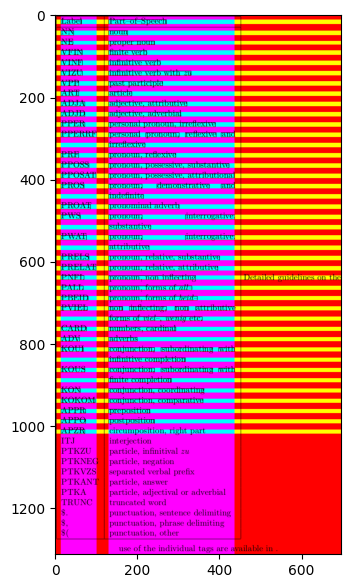

In [19]:
for c in cells_updt:
    lt, rb = (c['pos'][0], c['pos'][1]), (c['pos'][2], c['pos'][3])
    if c['flag'] == 1:
        cv.rectangle(img, lt, rb, (0,255,0), 1)
    elif c['flag'] == 2:
        cv.rectangle(img, lt, rb, (0,0,255), 1)
    else:
        cv.rectangle(img, lt, rb, (255,0,0), 1)
        
rMask, cMask = split_mask(img, cells)
MaskImg = np.stack([np.maximum(rMask, cMask)*255, 255-rMask*255, 255-cMask*255], axis=-1)
MaskImg = np.minimum(img, MaskImg)
view_imgs([MaskImg])

In [29]:
n_row_span_cells, n_col_span_cells = 0, 0

for c in cells_updt:
    if c['flag'] == 1: n_row_span_cells += 1
    elif c['flag'] == 2: n_col_span_cells += 1

n_row_span_cells, n_col_span_cells

(0, 1)

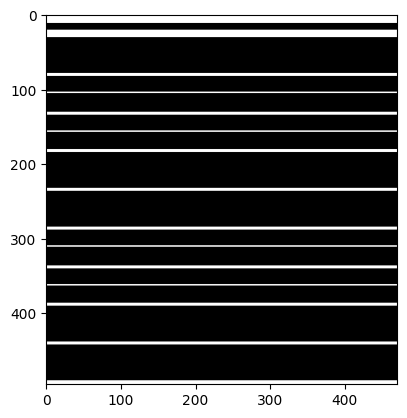

In [30]:
plt.imshow(rMask, cmap='gray')

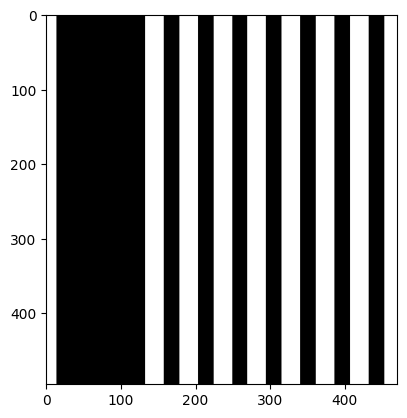

In [31]:
plt.imshow(cMask, cmap='gray')

In [32]:
cMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [33]:
def process_mask(rMask, cMask):
    res = {
        'rows': rMask[:, 0].tolist(),
        'columns': cMask[0, :].tolist()
    }
    return res

In [34]:
res = process_mask(rMask, cMask)
res['rows'][:20], res['columns'][:20]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [35]:
# create label folder for Split & Merge module if it hasn't been created
LABEL_TRAIN = os.path.join(SCITSR_TRAIN, 'label')

if not os.path.exists(LABEL_TRAIN):
    os.makedirs(LABEL_TRAIN)

In [36]:
def img_name_from_path(img_path):
    img_name = img_path.split(os.sep)[-1]
    names = img_name.split('.')[:-1]
    return '.'.join(names)

In [37]:
img_name = img_name_from_path(img_path)
img_name

'1211.6244v4.7'

In [42]:
def write_json(json_path, data):
    with open(json_path, 'w') as f:
        json.dump(data, f)

# Putting everything together

In [41]:
def prepare_label_split(folder_path: str, json_path: str):
    '''
    Params:
        folder_path -- string, path to either train or test folder
        json_path -- string, path to json file to write ground truth into
    Returns:
        None
    '''
    imgs_folder = os.path.join(folder_path, 'img') # access image folder
    imgs_paths = get_files([imgs_folder], 'png') # get list of image paths inside image folder
    os.makedirs(
        os.path.dirname(json_path), exist_ok=True
    )

    LABELS = {} 
    for i, img_path in enumerate(imgs_paths):
        img = load_img(img_path) # load image as numpy array 
        if img is None: continue
        # view_imgs([img])
        
        # Get table position inside pdf file
        img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')
        left, top, right, bottom = get_table_pos(img_pdf_path)
        
        # Read .chunk file to get coordinates of cells inside table
        # and convert from pdf coordinates to png coordinates
        img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')
        chunks = read_chunk(img_chunk_path, left, top)
        
        # Read .json file from structure folder to know whether a cell is a span-cell or single
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        n_rows, n_cols, cells = read_cells(img_struct_path)

        # update cells so that they have coordinates from chunks
        cells = update_cells(cells, chunks)

        # get row and columns mask (2D) and turn them each into 1D list 
        rMask, cMask = split_mask(img, cells)
        label = process_mask(rMask, cMask)

        # get image name and add to list of labels
        img_name = img_name_from_path(img_path)
        LABELS[img_name] = label
        if (i + 1) % 100 == 0: 
            print(f"Got labels for {i+1} images!")

    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [44]:
LABEL_TRAIN_SPLIT = os.path.join(SCITSR_TRAIN, 'label', 'split_label.json')
# print(LABEL_TRAIN_SPLIT)

prepare_label_split(SCITSR_TRAIN, LABEL_TRAIN_SPLIT)

Got labels for 100 images!
Got labels for 200 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/0705.1956v1.13.png
Got labels for 300 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/0804.1441v3.3.png
Got labels for 400 images!
Got labels for 500 images!
Got labels for 600 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1002.0561v1.6.png


libpng error: Read Error


Got labels for 700 images!
Got labels for 800 images!
Got labels for 900 images!
Got labels for 1000 images!
Got labels for 1100 images!
Got labels for 1200 images!
Got labels for 1300 images!
Got labels for 1400 images!
Got labels for 1500 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1210.6912v1.6.png
Got labels for 1600 images!
Got labels for 1700 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1303.6361v1.2.png


libpng error: Read Error


Got labels for 1800 images!
Got labels for 1900 images!
Got labels for 2000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1311.4166v1.6.png
Got labels for 2200 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1402.1107v1.1.png
Got labels for 2300 images!
Got labels for 2400 images!
Got labels for 2500 images!
Got labels for 2600 images!
Got labels for 2700 images!
Got labels for 2800 images!
Got labels for 2900 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1412.1842v1.3.png
Got labels for 3000 images!
Got labels for 3100 images!
Got labels for 3200 images!
Got labels for 3300 images!
Got labels for 3400 images!
Got labels for 3500 images!
Got labels for 3600 images!
Got labels for 3700 images!
Got labels for 3800 images!
Got labels for 3900 images!
* Error: Unable to read image from /Users/longhoang/

libpng error: Read Error


* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1707.09406v1.2.png
Got labels for 8200 images!
Got labels for 8300 images!
Got labels for 8400 images!
Got labels for 8500 images!
Got labels for 8600 images!
Got labels for 8700 images!
Got labels for 8800 images!
Got labels for 8900 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1711.01711v11.3.png
Got labels for 9000 images!
Got labels for 9100 images!
Got labels for 9200 images!
Got labels for 9300 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1712.01039v2.4.png
Got labels for 9400 images!
Got labels for 9500 images!
Got labels for 9600 images!
Got labels for 9700 images!
Got labels for 9800 images!
Got labels for 9900 images!
Got labels for 10000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1

libpng error: Read Error


* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1803.04786v1.4.png
Got labels for 10200 images!
Got labels for 10300 images!
Got labels for 10400 images!
Got labels for 10500 images!
Got labels for 10600 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1804.10337v1.1.png


libpng error: Read Error


Got labels for 10700 images!
Got labels for 10800 images!
Got labels for 10900 images!
Got labels for 11000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1805.10499v1.1.png
Got labels for 11100 images!
Got labels for 11200 images!
Got labels for 11300 images!
Got labels for 11400 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1807.02983v1.2.png


libpng error: Read Error


Got labels for 11500 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1807.04686v1.1.png
Got labels for 11600 images!
Got labels for 11700 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1808.02152v1.1.png
Got labels for 11800 images!
Got labels for 11900 images!
Got labels for 12000 images!


In [45]:
with open(LABEL_TRAIN_SPLIT, 'r') as f:
    data = json.load(f)

len(data)

11971

In [46]:
test_label = data[img_name]
test_label['rows'] == res['rows'], test_label['columns'] == res['columns'], \
len(test_label['rows']) == img.shape[0], len(test_label['columns']) == img.shape[1]

(True, True, True, True)

In [42]:
SPLIT_LABEL_TEST = os.path.join(SCITSR_TEST, 'label', 'split_label.json')

prepare_label_split(
    SCITSR_TEST,
    SPLIT_LABEL_TEST
)

Got labels for 100 images!
Got labels for 200 images!
Got labels for 300 images!
Got labels for 400 images!
Got labels for 500 images!
Got labels for 600 images!
Got labels for 700 images!
Got labels for 800 images!
Got labels for 900 images!
Got labels for 1000 images!
Got labels for 1100 images!
Got labels for 1200 images!
Got labels for 1300 images!
Got labels for 1400 images!
Got labels for 1500 images!
Got labels for 1600 images!
Got labels for 1700 images!
Got labels for 1800 images!
Got labels for 1900 images!
Got labels for 2000 images!
Got labels for 2100 images!
Got labels for 2200 images!
Got labels for 2300 images!
Got labels for 2400 images!
Got labels for 2500 images!
Got labels for 2600 images!
Got labels for 2700 images!
Got labels for 2800 images!
Got labels for 2900 images!
Got labels for 3000 images!
